# History Data-Driven Distributed Consensus in Networks

This notebook demonstrates how historical data can be used to enhance the quality of consensus decisions being made in a distributed setting. 



In [1]:
"""
Created on Sunday, Jan 03, 2021 
@author: vxr131730 - Venkatraman Renganathan 
         Control, Optimization & Networks Laboratory         
         The University of Texas at Dallas

This script is tested in Python 3.7, Windows 10, 64-bit
(C) Venkatraman Renganathan, 2020. Email: vrengana@utdallas.edu,
    Karthik Ganapathy, 2020. Email: karthik.ganapathy@utdallas.edu,
    Tyler Summers, 2020. Email: tyler.summers@utdallas.edu.

This program is a free software: you can redistribute it and/or modify it
under the terms of the GNU lesser General Public License, either version 
3.7, or any later version. This program is distributed in the hope that it 
will be useful, but WITHOUT ANY WARRANTY.
"""
###############################################################################
##################### IMPORT ALL THE REQUIRED LIBRARIES #######################
###############################################################################

# Import all the required libraries
import numpy as np
import cvxpy as cp
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from numpy import linalg as LA
from pyvis.network import Network
from numpy import random as npr

## Define the communication graph and visualize it

In [2]:
###############################################################################
##################### DEFINE THE COMMUNICATION GRAPH DETAILS ##################
###############################################################################

A = np.array([[0, 0, 0, 0, 1, 1, 1, 0],
              [0, 0, 0, 1, 1, 1, 0, 1],
              [0, 0, 0, 1, 1, 0, 1, 1],
              [0, 1, 1, 0, 0, 0, 0, 1],
              [1, 1, 1, 0, 0, 1, 1, 1],
              [1, 1, 0, 0, 1, 0, 1, 1],
              [1, 0, 1, 0, 1, 1, 0, 1],
              [0, 1, 1, 1, 1, 1, 1, 0]]) # Deterministic Adjacency Matrix

N = 10   # Desired number of agents 
p = 0.5  # Probability of edge connection for erdos-renyi graph

# Generate a connected random graph with N nodes
connectivityCheck = False
while connectivityCheck is False:
    G = nx.generators.random_graphs.erdos_renyi_graph(N, p)
    if nx.is_connected(G):
        A = nx.to_numpy_matrix(G) + np.identity(N)
        connectivityCheck = True

D = np.diagflat(A.sum(axis=1)) # Degree Matrix               
L = D - A       # Laplacian matrix
N = A.shape[0]  # Number of agents

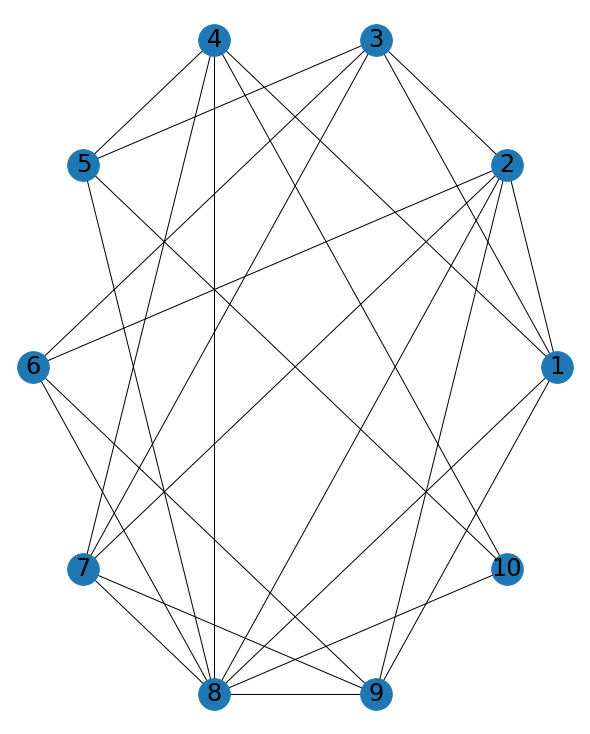

In [3]:
# Display The Communication Graph using networkx tools
G = nx.from_numpy_matrix(A)
labeldict = {}
for i in range(N):
    labeldict[i] = str(i+1)
plt.figure(figsize=(8,10))
nx.draw_circular(G, node_size=1000, labels = labeldict, with_labels = True, font_size = 24, font_color='k')

## Get neighbor information of all agents in network

In [4]:
def Get_Neighbors(i, L):
    """
    Function Get_Neighbors returns the list of in-neighbors of agent i at time k
    
    INPUTS:
    i : Index of the querying agent 
    L : Graph Laplacian Matrix
    
    OUTPUT:
    inNeighbors: Numpy array of values of neighbors
    """
    
    # Array of range of numbers from 1 to N representing agentIDs
    agentIDs = np.arange(N)+1
    
    # Extract the i^{th} column of Laplacian Matrix and stack it with neighbor values                      
    stackedCols = np.column_stack((agentIDs.reshape(-1,1), L[:,i]))    

    # Extract only in-neighbors & convert to list                           
    inNeighbors = np.ravel(stackedCols[np.where(stackedCols[:,1] < 0),0][0,:]).tolist()
    
    return inNeighbors

In [5]:
# Get neighbor information for all agents
neighborSets = []
for i in range(N):
    neighborSets.append(Get_Neighbors(i, L))
    iNeughbor = neighborSets[-1]
    print('The neighbors of agent', i+1, 'are:', neighborSets[-1])

The neighbors of agent 1 are: [2.0, 3.0, 4.0, 8.0, 9.0]
The neighbors of agent 2 are: [1.0, 3.0, 6.0, 7.0, 8.0, 9.0]
The neighbors of agent 3 are: [1.0, 2.0, 5.0, 6.0, 7.0]
The neighbors of agent 4 are: [1.0, 5.0, 7.0, 8.0, 10.0]
The neighbors of agent 5 are: [3.0, 4.0, 8.0, 10.0]
The neighbors of agent 6 are: [2.0, 3.0, 8.0, 9.0]
The neighbors of agent 7 are: [2.0, 3.0, 4.0, 8.0, 9.0]
The neighbors of agent 8 are: [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0]
The neighbors of agent 9 are: [1.0, 2.0, 6.0, 7.0, 8.0]
The neighbors of agent 10 are: [4.0, 5.0, 8.0]


## Define history of values of all agents along with their consensus for all past time steps

In [6]:
###############################################################################
##################### DEFINE THE SIMULATION PROBLEM DATA ######################
###############################################################################

HT = 5 # Length of historical values stored in rolling fashion    
XHistory = 50*npr.rand(N,HT) # Initial values of N agents for all HT times (Incremental storage or rolling storage)
meanHistory = np.mean(XHistory, axis=0) # Initial history of average for all HT times (Incremental storage or rolling storage)

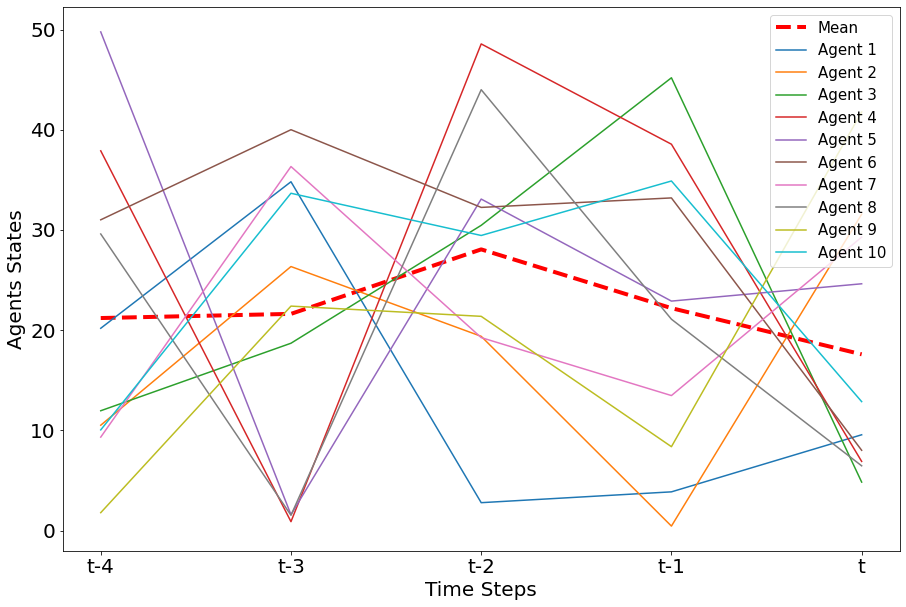

In [23]:
# Plot the historical values and average
timeVector = np.arange(HT)
legText = 'Agent '
legendText = ['Mean']
labText = ['t']
xlabels = []
for t in range(HT-1,-1,-1):
    addText = str(-(t))
    if t == 0:
        addText = ''
    labels.append('t'+addText)
#labels = ['t-4', 't-3', 't-2', 't-1', 't']
for i in range(N):
    legendText.append(legText+str(i+1))
plt.figure(figsize=(15,10))
plt.plot(timeVector, meanHistory, '--r', linewidth = 4)
plt.plot(timeVector, XHistory.T)
plt.xlabel("Time Steps", fontsize=20)
plt.ylabel("Agents States", fontsize=20)  
plt.xticks(timeVector, labels)
plt.tick_params(axis='both', labelsize=20) 
plt.legend(legendText, fontsize=15, loc='upper right')

## Define the $\epsilon$-neighborhood based set membership 
The confidence neighborhood around the $x_{i}(k)$ is defined as, 
\begin{align}
    \mathcal{B}_{x_{i}(k)}(\epsilon_{k}) = \left\{ y \in \mathbb{R} \mid \left \Vert y - x_{i}(k) \right \|_{2} \leq \epsilon_{k} \right\},
\end{align}   
where $\epsilon_{k} \in (0,1)$ is an user defined confidence bound at the time instance $k$.

In [ ]:
# Prepare epsilon radii throughout all past time stpes for all agents
epsBalls = np.zeros((N,HT))
ballScale = 0.1 
for k in range(HT-1,-1,-1):
    epsBalls[:,k] = ballScale*(k*np.ones(N) + npr.rand(N)) 
print(epsBalls)

In [ ]:
def Get_Neighbors_Values(i, k, L, X_k):
    """
    Function Get_Neighbors_Values returns the information state of in-neighbors of agent i at time k
    
    INPUTS:
    i : Index of the querying agent 
    k : Time instance
    L : Graph Laplacian Matrix
    X_k : Initial value of agents
    valueFlag: Flag to decide if values are to be returned along with neighbor ids
    
    OUTPUT:
    iNeighborsValues: Numpy array of values of neighbors values at time k
    """
    
    # Array of range of numbers from 1 to N representing agentIDs
    agentIDs = np.arange(N)+1
    
    # Extract the i^{th} column of Laplacian Matrix and stack it with neighbor values                      
    stackedCols = np.column_stack((agentIDs.T, X_k.T, L[:,i].T))

    # Extract only in-neighbors                            
    inNeighbors = stackedCols[np.where(stackedCols[:,2] < 0),:2][0,:]
    
    # Return the second column which has the values
    iNeighborsValues = inNeighbors[:,1]
    
    return iNeighborsValues
    

## Define the set membership counter
Using the confidence neighborhoods $\mathcal{B}_{x_{i}(k)}(\epsilon_{k})$, and the information sets $\mathfrak{X}^{T}_{i,i}, \mathfrak{X}^{T}_{i,\mathcal{N}_{i}}$, we define the set membership counter for all time steps $k = t-1, t-2, \dots, t-T$ as follows,
\begin{align}
    \mathfrak{N}^{i}_{k} = \left\{ j \in \mathcal{N}_{i} \mid x_{j}(k) \in \mathcal{B}_{x_{i}(k)}(\epsilon_{k}) \right\}.
\end{align}
Here, $\mathfrak{N}^{i}_{k}$ accounts for the neighbors $j \in \mathcal{N}_{i}$ who share their values in the vicinity of the agent $i$ in each time steps of the past history.

In [ ]:
def Obtain_Set_Membership_Counter(XHistory, epsBalls, neighborSets):
    """
    Function Obtain_Set_Membership_Counter returns the set membership counter information for all agents giving the information 
    as to which agent was always in the vicinity of the considered agents throughout the history.
    
    INPUTS:    
    XHistory: Historical data
    epsBalls: epsilon neighborhood for all past history
    neighborSets: List containing the neighbor information of all agents in network
    
    OUTPUT:
    setMembershipCounters: List of dictionaries; one for each agent in the network
    """
    # Infer the dimension of history
    HT = XHistory.shape[1]
    
    # Define a placeholder for setMembershipCounters
    setMembershipCounters = []
    
    # Loop through all agents across historical time steps to populate setMembershipCounters for each time instance in history 
    for i in range(N):    
        iNeighbors = neighborSets[i]
        setMembershipCounter = {}
        for k in range(HT):
            iAgentValue = XHistory[i,k]
            iNeighborsValues = Get_Neighbors_Values(i, k, L, XHistory[:,k])        
            for j in range(len(iNeighbors)):
                if abs(iAgentValue - iNeighborsValues[j]) <= epsBalls[i,k]:
                    setMembershipCounter["friendID"] = iNeighbors[j]
                    setMembershipCounter["timeInstant"] = k
        setMembershipCounters.append(setMembershipCounter)
    
    return setMembershipCounters

## Define the Frequency Counter for all neighbors
Frequency counter $\mathfrak{C}^{i}_{j}$ records the time indices $k$, where the neighbor $j \in \mathcal{N}_{i}$ had its value $x_{j}(k) \in \mathcal{B}_{x_{i}(k)}(\epsilon_{k})$. For all $j \in \mathcal{N}_{i}$ with $k = t-1,\dots,t-T$, 
\begin{align}
    \mathfrak{C}^{i}_{j} &= \left\{ k \mid j \in \mathfrak{N}^{i}_{k} \right\}.
\end{align}

In [ ]:
def Compute_Frequency_Counter(neighborSets, setMembershipCounters):
    """
    Function Compute_Frequency_Counter returns the recorded time indices, where 
    each neighbor j had their values in the vicinity of agent i
    
    INPUTS:
    neighborSets: List containing the neighbor information of all agents in network
    setMembershipCounters: List of dictionaries; one for each agent in the network
    
    OUTPUT:
    frequencyCounters: List of dictionaries; one for each agent in the network
    """

    # Obtain the dimension
    N = len(neighborSets)
    
    frequencyCounters = []
    for i in range(N):
        iNeighbors = neighborSets[i]
        iSetMembership = setMembershipCounters[i]
        frequencyCounter = []
        for j in range(len(iNeighbors)):
            jFrequencyCounter = {}    
            jFrequencyCounter["friendID"] = iNeighbors[j] 
            jFrequencyCounter["timeInstances"] = []
            if iSetMembership and iSetMembership["friendID"] == iNeighbors[j]:            
                jFrequencyCounter["timeInstances"].append(iSetMembership["timeInstant"])        
            frequencyCounter.append(jFrequencyCounter)
            print('Frequency Counter of Neighbor', iNeighbors[j] , 'for agent', i+1, 'is', jFrequencyCounter)
        frequencyCounters.append(frequencyCounter)
        
    return frequencyCounters
    

## Obtaining estimated mean & covariance of the neighbor configuration
The estimated mean $\hat{\mu}^{i}_{t}$ and estimated covariance $\hat{\Sigma}^{i}_{t}$ at time $t$ are computed as
\begin{align} 
    \left[\hat{\mu}^{i}_{t}\right]_{j} &=\frac{1}{T} \sum^{t-(T-1)}_{k = t} \left[\mathfrak{r}_{j}\right]_{k}, \quad j \in \mathcal{N}_{i}, \label{eqn_estim_mean} \\
    \hat{\Sigma}^{i}_{t} &= \frac{1}{T-1} \sum^{t-(T-1)}_{k=t} \left(\left[\mathcal{D}^{i}\right]_{*k} - \hat{\mu}^{i}_{t}\right) \left(\left[\mathcal{D}^{i}\right]_{*k} - \hat{\mu}^{i}_{t}\right)^{\top}. \label{eqn_estim_covar}
\end{align}

In [ ]:
def Estimate_Mean_And_Covariance(x_i, iNeighborsValues, frequencyCounters, meanHistory):
    """
    Function Estimate_Mean_And_Covariance returns the mean and covariance computed using the historical data
    
    INPUTS:
    x_i:
    iNeighborsValues:
    frequencyCounters:
    meanHistory:
    
    OUTPUTS:
    estMean:  Estimated Mean - numpy array of size (d_i,1)
    estCovar: Estimated covariance - numpy array of size (d_i,d_i)
    """
    
    # Obtain the required dimensions 
    d_i, HT = iNeighborsValues.shape[0], meanHistory.shape[0]
    
    # Define a discount factor, nu in [0.5,1)
    nu = 0.9
    
    # Define placeholders 
    estMean = np.zeros((d_i, 1))
    estCovar = np.zeros((d_i, d_i))
    distanceMatrix = np.zeros((d_i, HT))
    
    # Compute the estMean for all neighbors by computing their discounted importance vector and averaging it
    # Compute the estCovar by computing the normalized distance matrix
    for j in range(d_i): 
        jFrequencyCounter = frequencyCounters[j]
        importanceVector = np.zeros(HT)
        for k in range(HT):
            if jFrequencyCounter and jFrequencyCounter["timeInstances"] == k:
                importanceVector[k] = nu**(HT-k)            
            distanceMatrix[j,k] = LA.norm((iNeighborsValues[j] - meanHistory[k])/LA.norm(x_i - meanHistory[k]))
        estMean[j,:] = np.mean(importanceVector)
    for k in range(HT):
        estCovar += np.outer(distanceMatrix[:,k]-estMean, distanceMatrix[:,k]-estMean)  
    estCovar /= (HT-1)
    
    return estMean, estCovar

## SDP that finds the trustworthiness of all neighbors with high probability
\begin{equation} \label{eqn_final_sdp}
    \begin{aligned}
    \min_{z_{i},\xi,K, \lambda} &\quad \xi + \mathbf{Tr}\left( [\gamma_{2} \hat{\Sigma}^{i}_{t} + \hat{\mu}^{i}_{t} {\hat{\mu}^{i}_{t}}^{\top}]K \right)\\
    \text{s.t.} &\quad  \begin{bmatrix}
    R & 0.5r \\ 0.5r^{\top} & c \end{bmatrix} \preceq \lambda \hat{S}, \\
    &\quad z_{i} \in [-1,1]^{d_{i}}, \xi \in \mathbb{R}, K \in \mathbb{S}^{d_{i}}_{+}, \lambda \geq 0,
    \end{aligned}
\end{equation}

where $R = -K, r = (\alpha_{2} - \alpha_{1}) z_{i}, c = \alpha_{1} \mathbf{1}^{\top}_{d_{i}} z_{i} - \xi$ and $\hat{S} = \begin{bmatrix}
    {(\hat{\Sigma}^{i}_{t})}^{-1}  &  -{(\hat{\Sigma}^{i}_{t})}^{-1} \, \hat{\mu}^{i}_{t} \\  -{\hat{\mu}^{i}_{t}}^{\top} \, {(\hat{\Sigma}^{i}_{t})}^{-1}  & {\hat{\mu}^{i}_{t}}^{\top} {(\hat{\Sigma}^{i}_{t})}^{-1} \hat{\mu}^{i}_{t} - \gamma_{1}  
    \end{bmatrix}.$

In [ ]:
def Solve_SDP(muHat, sigmaHat, gamma1, gamma2, alfa1, alfa2):
    """
    Function Solve_SDP returns the solution of a semidefinite program specified using the DRSP model
    
    INPUTS:
    muHat    : Estimated mean
    sigmaHat : Estimated covariance
    gamma1   : Size of ellipsoid quantifying uncertainty about computed mean
    gamma2   : Size of cone constraint enforced on the uncertainty about computed covariance
    alfa1    : Weighting for first cost component
    alfa2    : Weighting for second cost component
    
    OUTPUT:
    neighborTrusts: Numpy array defining the trustworthiness of all neighbors    
    """
    
    # Get the dimension of the problem
    d_i = sigmaHat.shape(0)
    
    # Get inverse covariance matrix
    sigmaHatInv = LA.inv(sigmaHat)  
    
    # Form \hat{S} matrix
    hatS1 = sigmaHatInv
    hatS2 = -sigmaHatInv@muHat
    hatS3 = muHat.T@sigmaHatInv@muHat-gamma1
    hatS  = np.block([[hatS1,   hatS2],
                      [hatS2.T, hatS3]])
    
    # Define SDP variables
    zeta, lamda = cp.Variable(), cp.Variable()
    z, K = cp.Variable(d_i), cp.Variable((d_i,d_i), PSD=True)
    
    # Form the B matrix
    R = -K
    r = 0.5*(alfa2 - alfa1)*z
    c = alfa1*cp.matmul(np.ones(1,d_i),z) - zeta
    B = cp.bmat([[R,   r],                      
                 [r.T, c]])  
    
    # Define the Constraints
    constraints = [lamda >= 0]
    for k in range(d_i):
        constraints += [z[k] >= -1]
        constraints += [z[k] <= 1]
    constraints += [B << lamda*hatS]
    
    # Define the objective function of SDP to be solved
    objFn = zeta + cp.trace((gamma2*sigmaHat + muHat@muHat.T)@K)
    
    # Define the convex optimization problem with constraints   
    cvxProb = cp.Problem(cp.Minimize(objFn), constraints) 
    
    # Solve the SDP
    cvxProb.solve()
    
    # Extract the solution    
    neighborTrusts = z.value
    neighborTrusts = neighborTrusts.reshape(d_i,1)

    return neighborTrusts

## A Data-Driven Distributionally Robust $(D^{3}R)$ Trust-Based Consensus Algorithm
Every reliable agent $i \in \mathcal{V}$ updates its states using the following proposed $(D^{3}R)$ trusted consensus protocol namely
\begin{align} 
    x_{i}(t+1) &= \sum_{j \in \mathcal{J}_{i}} w_{ij}(t) x_{j}(t), \quad \text{with weights}, \label{eqn_d3r_update}\\
    w_{ij}(t) &= 1 - \frac{[\bar{z}^{\dagger}_{i}]_{j}}{\left\Vert \bar{z}^{\dagger}_{i}\right \|}, \quad j \in \mathcal{J}_{i}. \label{eqn_d3r_wt}
\end{align}

In [ ]:
def D3R_Consensus_Protocol(xNow, iNeighborsValues, neighborTrusts):
    """
    Function D3R_Consensus_Protocol updates the state of each vehicles after computing the trustworthiness of all in-neighbors
    
    INPUTS:
    xNow: 
    iNeighborsValues: 
    neighborTrusts:
    
    OUTPUT:
    xNext: Next state
    """   
    
    # Convert the trusts to weights to be used in the consensus update
    # Append with -1 as agent i is sure that it is self reliable 100%
    inclusiveNeighborTrusts = np.append(-1, neighborTrusts)
    
    # Get the new dimension
    totalInNeighbors = inclusiveNeighborTrusts.shape[0]
    
    # Calculate the weight
    weights = np.ones(totalInNeighbors,1) - inclusiveNeighborTrusts/LA.norm(inclusiveNeighborTrusts)    
    
    # Append the ith agent values with neighbors to form inclusive neighbor values
    xvalues = np.append(xNow, iNeighborsValues)
    
    # Compute the weighted average
    xNext = np.average(xvalues, weights=weights)
    
    return xNext

## Main Simulation Start

In [ ]:
# Get the Safe consensus updates for all time steps
T = 50 # Future Time Span   
x = np.zeros((N,T+1))
xMeans = np.zeros(T+1)
x[:,0] = XHistory[:,0]
xMeans[0] = np.mean(x[:,0])
gamma1 = 0.5
gamma2 = 0.8
alfa1 = 0.4
alfa2 = 1 - alfa1

for t in range(T):
    for i in range(N):
        # Get the neighbors of agent i
        iNeighbors = neighborSets[i]
        
        # Get the neighbors' state value
        iNeighborsValues = Get_Neighbors_Values(i, k, L, x[:,t])
        
        # Get the set membership counter
        setMembershipCounters = Obtain_Set_Membership_Counter(XHistory, epsBalls, neighborSets)
        
        # Get the frequency counters
        frequencyCounters = Compute_Frequency_Counter(neighborSets, setMembershipCounters)
        
        # Estimate the mean and covariance of the neighbor configuration
        estMean, estCovar = Estimate_Mean_And_Covariance(x[i,t], iNeighborsValues, frequencyCounters, meanHistory)
        
        # Compute the neighborTrusts using the SDP
        neighborTrusts = Solve_SDP(estMean, estCovar, gamma1, gamma2, alfa1, alfa2)
        
        # Update using the D3R_Consensus_Protocol
        x[i,t+1] = D3R_Consensus_Protocol(weights, x[i,t], iNeighborsValues, neighborTrusts) 
    
    # Once all agents update their values based on their respective neighbor trusts, update the overall average
    xMeans[t+1] = np.mean(x[:,t+1])
    
    # Update the historical information
    # Rolling horizon fashion: if XHistory = [1 2 3 4 5], x_{t+1} = 0, then fill as XHistory = [0 1 2 3 4]
    # Append Fashion: if XHistory = [1 2 3 4 5], x_{t+1} = 0, then fill as XHistory = [0 1 2 3 4 5]
    XHistory = np.concatenate((x[:,t+1], XHistory[:,:-2]) # Rolling horizon fashion
    

In [ ]:
# Plot the historical values and average
timeVector = np.arange(T)
legText = 'Agent '
legendText = ['Mean']
for i in range(N):
    legendText.append(legText+str(i+1))
plt.figure(figsize=(15,10))
plt.plot(timeVector, xMeans, '--r', linewidth = 4)
plt.plot(timeVector, x.T)
plt.xlabel("Time Steps", fontsize=20)
plt.ylabel("Agents States", fontsize=20)    
plt.tick_params(axis='both', labelsize=20) 
plt.legend(legendText, fontsize=15, loc='upper right')